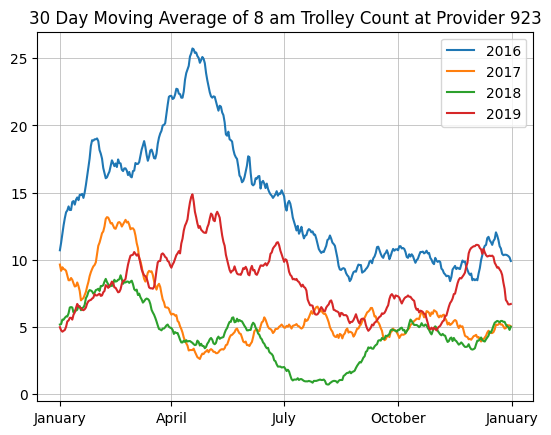

In [1]:
import pandas as pd
import warnings
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

os.chdir('C:/Users/C10381149/OneDrive - Technological University Dublin/Documents/Python/Datasets/')

t=pd.read_csv('TrolleyGAR.csv')
t.columns=['provider','date','total8am','total8pm','total2pm']
t=t.drop(columns=['total8pm','total2pm'])
t.date=pd.to_datetime(t.date, format='%d/%m/%Y')

t923=t.query("provider==923 and date < '2020-01-01'")[
['date','total8am']].reset_index(drop=True)

t923['30DMA']=0
for i in range(len(t923)):
    date_i = t923.loc[i, 'date']
    last_30_days = pd.date_range(end=date_i, periods=30)
    moving_average_i = t923[t923.date.isin(last_30_days)].total8am.mean()
    t923.loc[i, '30DMA'] = moving_average_i

t923=t923.sort_values('date').reset_index(drop=True)

plotDF=t923.dropna()
plotDF['year']=plotDF.date.dt.year
plotDF['month']=plotDF.date.dt.month
plotDF['day']=plotDF.date.dt.day
plotDF['chart_date']=plotDF.date.dt.strftime('2019-%m-%d')
plotDF.loc[(plotDF.month==2) & (plotDF.day==29),'chart_date'] = ''
plotDF['chart_date']=pd.to_datetime(plotDF.chart_date)
plotDF=plotDF.query("year > 2015").pivot(
    index='chart_date', columns='year', values='30DMA').dropna()

fig, ax = plt.subplots()
ax.plot(plotDF)
ax.legend(labels=['2016','2017','2018','2019'])
ax.set_title('30 Day Moving Average of 8 am Trolley Count at Provider 923')
xticks=pd.to_datetime(['2019-01-01','2019-04-01','2019-07-01','2019-10-01','2020-01-01'])
xlabs=['January','April','July','October','January']
ax.set_xticks(ticks=xticks, labels=xlabs)
ax.set_xlabel('')
ax.grid(linewidth=.5)
plt.show()

In [12]:
b=t923.query("date < '2019-01-01'")
b=b[b.total8am.isna()==False].reset_index(drop=True)

In [21]:
newCols=['lag_'+str(i)+'d' for i in range(1,31)]
for c in newCols:
    b[c] = 0

for i in range(len(b)):
    date_i=b.loc[i, 'date']
    for j in range(1,31):
        date_i_minus_j=date_i - pd.Timedelta(j,'d')
        if date_i_minus_j in list(b.date):
            lagged_value=float(b[b.date == date_i_minus_j]['total8am'])
            colName='lag_'+str(j)+'d'
            b.loc[i, colName] = lagged_value

b['year']=b.date.dt.year
b['month']=b.date.dt.month
b['day']=b.date.dt.day
b['day_of_week']=b.date.dt.day_of_week
features=newCols+['day_of_week','month']

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [33]:
ct = ColumnTransformer([
    ("standard",StandardScaler(),newCols),
    ("onehot",OneHotEncoder(drop='first',sparse_output=False,dtype=int),['day_of_week','month'])
]).fit(b[features])

In [34]:
#X=pd.get_dummies(b[features],columns=['day_of_week','month'],drop_first=True, dtype=int)
X = ct.transform(b[features])
y = b.total8am
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
forest=RandomForestRegressor(n_estimators=20, random_state=2).fit(X_train, y_train)
print("Training score: {:.3f}".format(forest.score(X_train,y_train)))
print("Test score: {:.3f}".format(forest.score(X_test,y_test)))

Training score: 0.930
Test score: 0.581


In [35]:
from sklearn.linear_model import LinearRegression
lm=LinearRegression().fit(X_train,y_train)
print("Training score: {:.3f}".format(lm.score(X_train,y_train)))
print("Test score: {:.3f}".format(lm.score(X_test,y_test)))

Training score: 0.611
Test score: 0.608


In [38]:
predicted_df=b.query("date < '2018-01-01'")[['date','total8am']]
true_df=b.query("date < '2019-01-01'")[['date','total8am']]

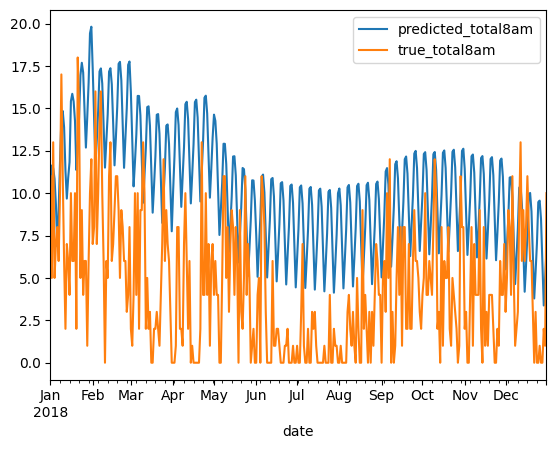

In [39]:
while predicted_df.date.max() < pd.to_datetime('2019-01-01'):
    next_date=predicted_df.date.max() + pd.Timedelta(1,'d')
    X_new=pd.DataFrame({'date':[next_date]})
    X_new['day_of_week']=X_new.date.dt.day_of_week
    X_new['month']=X_new.date.dt.month
    date_i=X_new.loc[0, 'date']
    for j in range(1,31):
        date_i_minus_j=date_i - pd.Timedelta(j,'d')
        if date_i_minus_j in list(predicted_df.date):
            lagged_value=float(predicted_df[predicted_df.date == date_i_minus_j]['total8am'])
            colName='lag_'+str(j)+'d'
            X_new.loc[0, colName] = lagged_value

    X_new=X_new.drop(columns='date')
    
    predicted_df=pd.concat(
        [predicted_df, 
         pd.DataFrame(
             {'date':[next_date], 
              'total8am':float(lm.predict(ct.transform(X_new)))
             }
         )
        ]
    )
    
    predicted_df=predicted_df.reset_index(drop=True)

pdf=pd.merge(
    left=predicted_df.rename(columns={'total8am':'predicted_total8am'})[['date','predicted_total8am']],
    right=true_df.query("date >= '2018-01-01'").rename(
        columns={'total8am':'true_total8am'})[['date','true_total8am']],
    on='date')

pdf.plot(x='date')
plt.show()